In [1]:
from nnsight import LanguageModel
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import json
import time
from utils.activations import load_activations
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
from utils.train_probe_v2 import LinearProbe
from tqdm import tqdm
import gc


/root/temperature_probe/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
torch.load("/workspace/activations/Qwen3-8B/temperature_0.25/0.pt").shape

torch.Size([8, 2334, 4096])

In [5]:
torch.load("/workspace/activations/Qwen3-8B/temperature_0.25/prompts.pt")

["<|im_start|>user\nCan you recommend a chocolate cake recipe for two?<|im_end|>\n<|im_start|>assistant\n<think>\nOkay, the user is asking for a chocolate cake recipe for two. Let me think about how to approach this. First, I need to consider the typical ingredients for a chocolate cake and adjust the quantities to serve two people. Regular recipes are usually for larger batches, so scaling down is essential.\n\nI should start by recalling a standard chocolate cake recipe. Let me think... maybe a basic butter cake with cocoa powder. The key ingredients would be flour, sugar, cocoa, eggs, butter, milk, baking powder, and maybe some vanilla extract. Also, the frosting is important for a complete cake. Since it's for two, maybe a simple frosting like buttercream would work.\n\nWait, the user might not have a lot of ingredients, so I should keep it simple. Let me check the original recipe. Let's say a standard 8-inch cake is for 8-10 people. To make it for two, I need to scale down the ing

In [3]:
activations_dir = "/workspace/activations/Qwen3-0.6B"

In [4]:
all_acts = []

In [ ]:
all_fnames = []
for temp in sorted(os.listdir(activations_dir)):
    fnames = [fname for fname in os.listdir(os.path.join(activations_dir, temp))[:30] if not fname.startswith('prompts')]
    all_fnames.extend([(temp, fname) for fname in fnames])

for temp, fname in tqdm(all_fnames, desc="Processing activation files"):
    acts = torch.load(os.path.join(activations_dir, temp, fname))
    layer_acts = acts[19]
    all_acts.append(layer_acts)
    del acts
    gc.collect()


Processing activation files:   0%|          | 1/210 [00:00<01:50,  1.88it/s]

Processing activation files: 100%|██████████| 210/210 [02:09<00:00,  1.62it/s]


In [6]:
probe_weights = torch.load(os.path.join("models", 'layer_19.pt'), weights_only=False)

In [7]:
probe = LinearProbe(1024)
probe.load_state_dict(probe_weights["model_state_dict"])

<All keys matched successfully>

In [44]:
# Load the saved mean and std from the checkpoint
probe_weights = torch.load(os.path.join("models", 'layer_19.pt'), weights_only=False)
probe = LinearProbe(1024)
probe.load_state_dict(probe_weights["model_state_dict"])

# Get the saved mean and std used during training
X_mean = probe_weights['X_mean']  # Shape: (1, 1024)
X_std = probe_weights['X_std']    # Shape: (1, 1024)

# Now scale correctly
monitor = []
for act in all_acts:
    # act[0] has shape (batch, seq_len, hidden_dim) or (seq_len, hidden_dim)
    # Standardize using the training statistics
    act_scaled = (act[0] - X_mean) / X_std
    pred = 1.5 - probe(act_scaled).detach().cpu().numpy()
    monitor.append(pred)

In [39]:
labels = [0] * 30 + [0.25] * 30 + [0.5] * 30 + [0.75] * 30 + [1] * 30 + [1.25] * 30 + [1.5] * 30

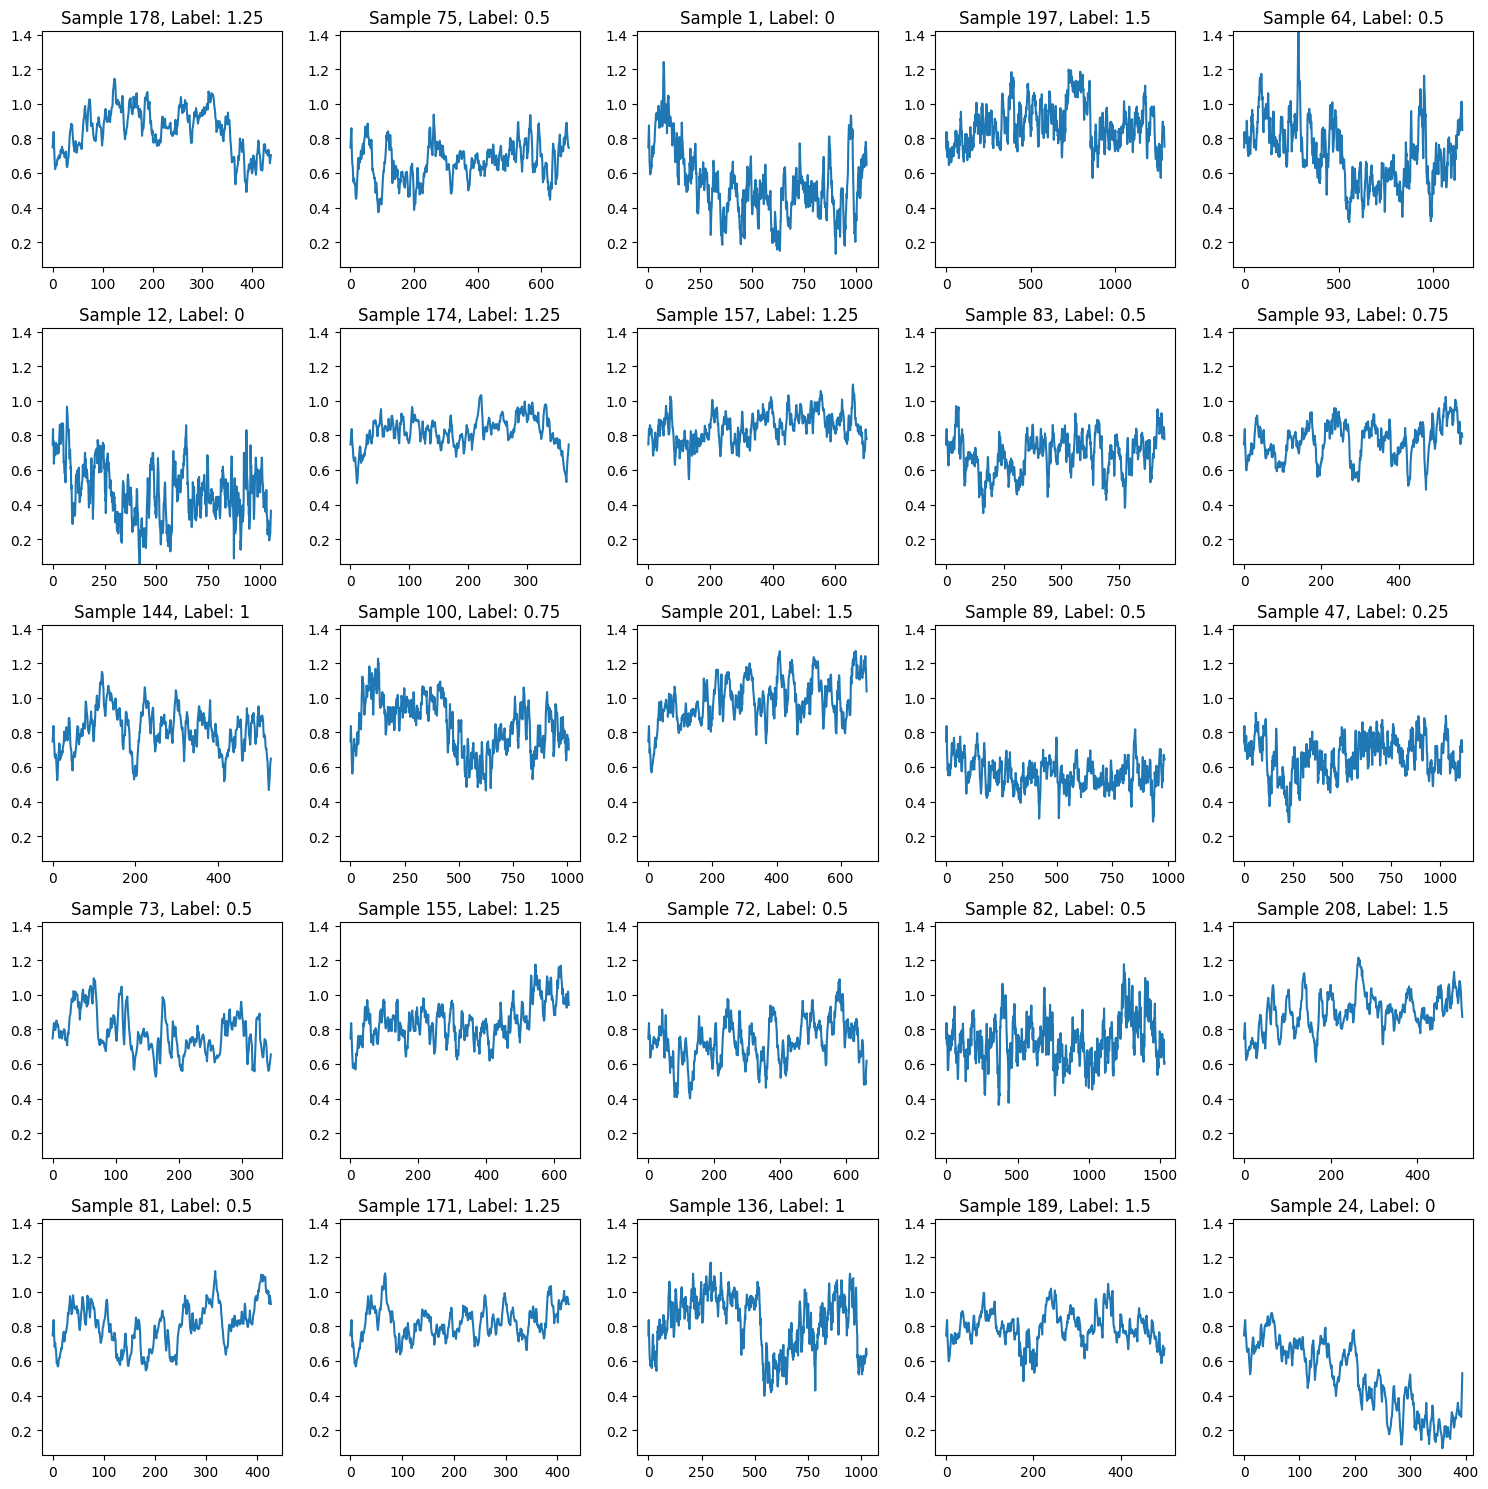

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import random

def ema(arr, alpha=0.95):
    """
    Apply Exponential Moving Average smoothing.
    Args:
        arr: 1D np array (sequence)
        alpha: Smoothing factor (0 < alpha < 1)
    Returns:
        smoothed array, same shape
    """
    arr = np.asarray(arr)
    if arr.ndim != 1:
        arr = arr.flatten()
    ema_arr = np.zeros_like(arr, dtype=np.float32)
    if len(arr) == 0:
        return ema_arr
    ema_arr[0] = arr[0]
    for i in range(1, len(arr)):
        ema_arr[i] = alpha * arr[i] + (1 - alpha) * ema_arr[i-1]
    return ema_arr

# Randomly pick 25 indices from monitor
num_samples = min(25, len(monitor))
selected_indices = random.sample(range(len(monitor)), num_samples)
selected_outputs = [monitor[i] for i in selected_indices]

# Compute min and max across all smoothed outputs to set y-axis limits
all_smoothed = []
for output in selected_outputs:
    output_flat = np.array(output).flatten()
    smoothed = ema(output_flat[1:], alpha=0.2)
    all_smoothed.append(smoothed)
all_min = min(np.min(sm) for sm in all_smoothed)
all_max = max(np.max(sm) for sm in all_smoothed)

fig, axes = plt.subplots(5, 5, figsize=(15, 15))

for idx, ax in enumerate(axes.flat):
    if idx < num_samples:
        output = selected_outputs[idx]
        try:
            output_flat = np.array(output).flatten()
            smoothed = ema(output_flat, alpha=0.2)
            ax.plot(smoothed)
            ax.set_ylim(all_min, all_max)
        except Exception as e:
            ax.text(0.5, 0.5, f'Error\n{e}', ha='center', va='center')
        ax.set_title(f"Sample {selected_indices[idx]}, Label: {labels[selected_indices[idx]]}")
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()


Total sampled points: 2100
Expected: 2100


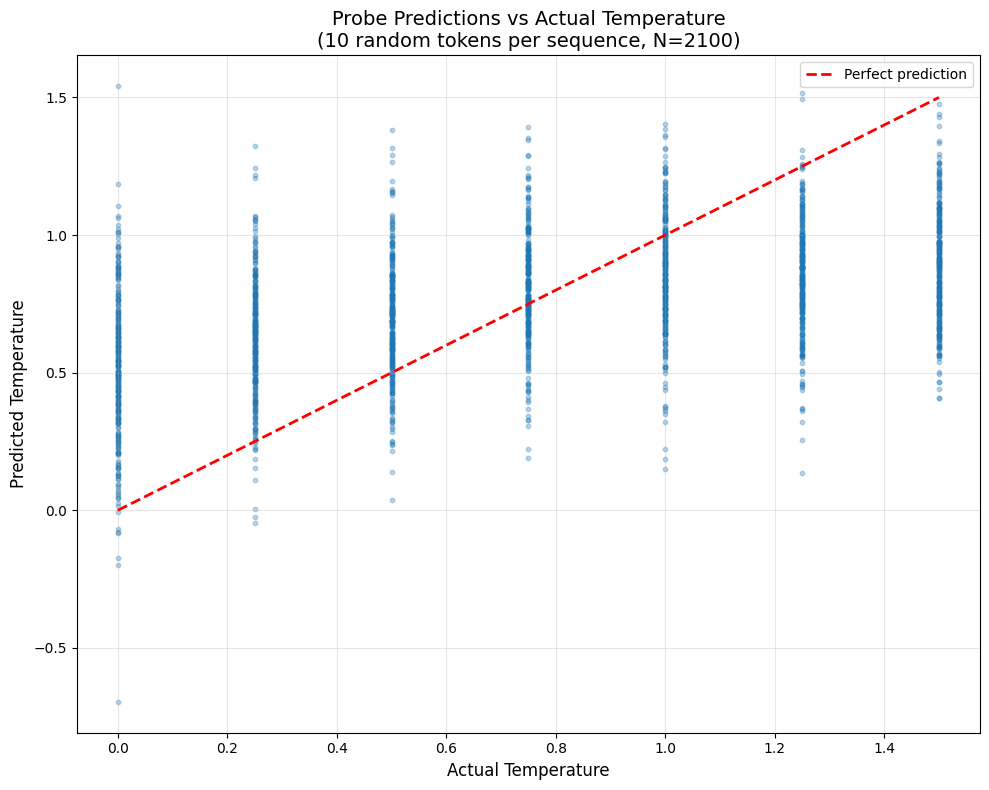


RMSE: 0.4372
R²: 0.2354


In [46]:
# Scatter plot: predictions vs actuals
# Sample 10 random token indices from each sequence (210 sequences × 10 tokens = 2100 points)

predictions_sampled = []
actuals_sampled = []

np.random.seed(42)  # For reproducibility

for seq_idx in range(len(monitor)):
    # monitor[seq_idx] has shape (seq_len, 1) or (seq_len,)
    preds = np.array(monitor[seq_idx]).flatten()
    seq_len = len(preds)
    
    # Randomly sample 10 token indices from this sequence
    if seq_len >= 10:
        sampled_indices = np.random.choice(seq_len, size=10, replace=False)
    else:
        # If sequence is shorter than 10, sample with replacement
        sampled_indices = np.random.choice(seq_len, size=10, replace=True)
    
    # Get predictions for sampled tokens
    sampled_preds = preds[sampled_indices]
    
    # Get actual temperature label for this sequence
    actual_temp = labels[seq_idx]
    
    # Store all 10 sampled points
    predictions_sampled.extend(sampled_preds)
    actuals_sampled.extend([actual_temp] * 10)

# Convert to numpy arrays
predictions_sampled = np.array(predictions_sampled)
actuals_sampled = np.array(actuals_sampled)

print(f"Total sampled points: {len(predictions_sampled)}")
print(f"Expected: {len(monitor) * 10}")

# Create scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(actuals_sampled, predictions_sampled, alpha=0.3, s=10)
plt.plot([min(actuals_sampled), max(actuals_sampled)], 
         [min(actuals_sampled), max(actuals_sampled)], 
         'r--', label='Perfect prediction', linewidth=2)
plt.xlabel('Actual Temperature', fontsize=12)
plt.ylabel('Predicted Temperature', fontsize=12)
plt.title('Probe Predictions vs Actual Temperature\n(10 random tokens per sequence, N=2100)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print statistics
from sklearn.metrics import mean_squared_error, r2_score
rmse = np.sqrt(mean_squared_error(actuals_sampled, predictions_sampled))
r2 = r2_score(actuals_sampled, predictions_sampled)
print(f"\nRMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")
